In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from datetime import datetime  
from datetime import timedelta, date
from scipy.optimize import fsolve
plt.style.use('seaborn')
%matplotlib inline

In [11]:
global_confirmed_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
global_deaths_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"

US_confirmed_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"
US_deaths_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv"

In [12]:
# Filter data by country
def clean_country(url1, url2):
    data1 = pd.read_csv(url1)
    data2 = pd.read_csv(url2)
    country_list = data1['Country/Region'].values
    country = str(input("Select a country: "))
    while not country in country_list:
        country = str(input("Cannot find that country. Try again: "))
    choice = data1['Country/Region'] == country
    data1 = data1[choice]
    data1 = data1.iloc[:,4:]
    data1 = data1.sum()
    days = np.arange(len(data1))
    data2 = data2[choice]
    data2 = data2.iloc[:,4:]
    data2 = data2.sum()
    days = np.arange(len(data1))
    return country, days, data1, data2

# Filter data by state in U.S
def clean_state(url1, url2):
    data1 = pd.read_csv(url1)
    data2 = pd.read_csv(url2)
    state_list = data1['Province_State'].values
    state = str(input("Select a U.S state: "))
    while not state in state_list:
        state = str(input("Cannot find that state. Try again: "))
    filtER = data1['Province_State'] == state
    data1 = data1[filtER]
    data2 = data2[filtER]
    data1 = data1.iloc[:,11:]
    data2 = data2.iloc[:,12:]
    data1 = data1.sum()
    data2 = data2.sum()
    days = np.arange(len(data1))
    return state, days, data1, data2

In [13]:
# Reported confirmed,deaths, and recovered cases in the U.S.
# This model's main assumption is human intervention. 

In [14]:
def logistic_model(t,k,t_star,M):
    return (M)/(1+np.exp(-(t-t_star)/k))

# The error function calculates the % error of yesterday's predictions vs. today's data
def error(function, x, y, z):
    t0 = date(2020,1,22)
    today = date.today()
    delta = today - t0
    fit = curve_fit(function, x[:-2], y[:-2])
    param = fit[0]
    rate = param[0]
    t_star = param[1]
    carry_cap = param[2]
    
    mortality_rate = (z[-2])/(y[-2]) # Latest total confirmed deaths / total confirmed cases
    predicted_deaths = mortality_rate * carry_cap
    
    days_til_today = delta.days 
    pred_inf = logistic_model(days_til_today, rate, t_star, carry_cap)
    
    inf_error = abs((pred_inf - y[-1])/y[-1])
    deaths_error = abs((predicted_deaths - z[-1])/ z[-1])
    return inf_error, deaths_error

In [18]:
def analyze(function, x, y, z, location):
    t0 = date(2020,1,22)
    
    # Function will return rate of change, t* & carrying capacity
    fit = curve_fit(function, x, y)
    param = fit[0]
    cov = fit[1]
    rate = param[0]
    t_star = param[1]
    carry_cap = param[2]
    errors = [np.sqrt(cov[i][i]) for i in [0,1,2]]
    
    mortality_rate = (z[-1])/(y[-1]) # Latest total confirmed deaths / total confirmed cases
    exp_deaths = mortality_rate * carry_cap # Expected end date deaths = MR * Carrying Capacity

    print("The current infected population in",location, "is", int(y[-1]))
    print("The current mortality rate is", round((mortality_rate*100),2),"%")
    
    # Printing out the data
    t_starDate = t0 + timedelta(days= t_star)
    t_starDate= t_starDate.strftime("%m/%d/%Y")
    print("The infection rate is", round(rate,0), "with the standard error of", round(errors[0],3))
    print("The date with the highest infection rate", t_starDate)
    print("The estimated carrying capacity is", int(carry_cap), "+/-", int(errors[2]),"people")
    
    # Calculating the percentage error from yesterday's predictions
    inf_error, deaths_error = error(function, x, y, z)
    
    # Predicting tomorrow's infections & deaths
    tomorrow = date.today() + timedelta(days=1)
    tomorrow_date = tomorrow.strftime("%m/%d/%Y")
    delta = tomorrow - t0 # Days between tomorrow's date & 1/22/20
    days_til_tomorrow = delta.days 
    
    exp_inf = logistic_model(days_til_tomorrow, rate, t_star, carry_cap)
    tmr_exp_inf = exp_inf - y[-1]
    
    print("The estimated number of new cases for", tomorrow_date, "is", int(tmr_exp_inf), "+/-", 
           int(inf_error*tmr_exp_inf), "people")
    
    tmr_exp_deaths = int(mortality_rate * tmr_exp_inf)
    print("The estimated number of new deaths for", tomorrow_date, "is", tmr_exp_deaths,"+/-", 
          int(deaths_error*tmr_exp_deaths),"people")
    
    # Plotting the logistic curve
    plt.figure(figsize=(6, 6))
    
    # Real data
    plt.scatter(x, y ,label = "Real Data", color = "r")
    
    # Predicted logistic curve
    plt.scatter(days_til_tomorrow, exp_inf, linewidth = 1, color = 'k', label = "Tomorrow's Prediction")
    
    # Solving & predicting the end date
    sol = int(fsolve(lambda x : function(x,rate,t_star,carry_cap) - int(carry_cap), t_star))
    EndDate = t0 + timedelta(days = sol)
    EndDatenew = EndDate.strftime("%m/%d/%Y")
    EndDate_MR = (exp_deaths/carry_cap)*100
    
    pred_x = list(range(max(x),sol))
    future = list(x) + pred_x
    pred_list = []
    for i in future:
        pred = logistic_model(i, rate, t_star, carry_cap)
        pred_list.append(pred)
    peak_days = future[np.argmax(pred_list)]
    peak_date = t0 + timedelta(days = peak_days)
    peak_date = peak_date.strftime("%m/%d/%Y")
    
    plt.plot(future, [logistic_model(i,rate,t_star,carry_cap) for i in future], linestyle = '--', lw = 2, label = "Logistic Model")
    plt.title("COVID-19 Logistic Curve in "+ location, fontsize = 15)
    plt.legend(loc = 'best', fontsize = 13)
    plt.xlabel("Days since Jan 22nd 2020", fontsize = 13)
    plt.ylabel("Total Number of Infected People", fontsize = 13)
    plt.ylim((min(y),carry_cap*1.1))
    plt.xticks(fontsize = 13)
    plt.yticks(fontsize = 13)
    plt.show()
    print("The estimated date with peak infections is", peak_date, "with", int(max(pred_list)), "people")
    print("The estimated end date is", EndDatenew)
    print("The estimated number of deaths by end date is", int(exp_deaths))
    print("The expected end date mortality rate is", round(EndDate_MR,2),"%")

In [19]:
def menu(global_confirmed_url,global_deaths_url, US_confirmed_url, US_deaths_url):
    selection = 0
    while selection != 3:
        print("1. Analyze a country")
        print("2. Analyze a U.S state or region")
        print("3. Quit")
        selection = int(input("Please enter a selection: "))
        if selection == 1:
            country, days, country_confirmed, country_deaths = clean_country(global_confirmed_url, global_deaths_url)
            analyze(logistic_model, days, country_confirmed, country_deaths, country)
        elif selection == 2:
            state, days, state_confirmed, state_deaths = clean_state(US_confirmed_url, US_deaths_url)
            analyze(logistic_model, days, state_confirmed, state_deaths, state)
        elif selection == 3:
            print("Goodbye & stay healthy!")
            break

1. Analyze a country
2. Analyze a U.S state or region
3. Quit
Please enter a selection: 1
Select a country: California
Cannot find that country. Try again: US
The current infected population in US is 213372
The current mortality rate is 2.23 %
The infection rate is 4.0 with the standard error of 0.048
The date with the highest infection rate 03/30/2020
The estimated carrying capacity is 332229 +/- 7223 people
The estimated number of new cases for 04/03/2020 is 36224 +/- 540 people
The estimated number of new deaths for 04/03/2020 is 807 +/- 116 people


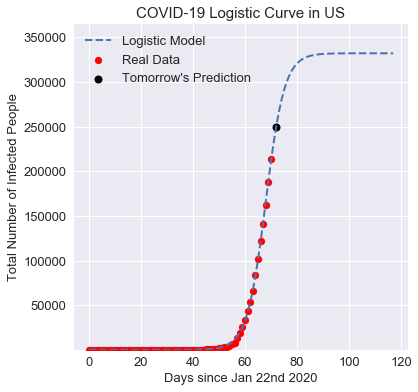

The estimated date with peak infections is 05/18/2020 with 332228 people
The estimated end date is 05/19/2020
The estimated number of deaths by end date is 7406
The expected end date mortality rate is 2.23 %
1. Analyze a country
2. Analyze a U.S state or region
3. Quit
Please enter a selection: 3
Goodbye & stay healthy!


In [20]:
menu(global_confirmed_url, global_deaths_url, US_confirmed_url, US_deaths_url)